In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EO-LEARN PIPELINE

## Imports

In [64]:
### Data manipulation ###
import pandas as pd
import numpy as np
import geopandas as gpd
from bs4 import BeautifulSoup
import rasterio
from shapely.geometry import Polygon

### Utils ###
from datetime import datetime
import os
import sys
from satellitecrops.utils.sql_connector import SQLConnection
import tqdm

### Data viz ###
import matplotlib.pyplot as plt

### EO-Learn / SentinelHub ###
from sentinelhub import UtmZoneSplitter, BBox, CRS
from eolearn.core import (
    EOPatch,
    EOExecutor,
    FeatureType,
    EOTask,
    SaveTask,
    OverwritePermission,
    EOWorkflow,
    linearly_connect_tasks
    )
from eolearn.io import SentinelHubInputTask, VectorImportTask
from eolearn.geometry import VectorToRasterTask


## Environnement variables

In [7]:
# TODO : Use var env for region selection
REGION = "pays_basque" # ~zone
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), "data", "region", REGION)
EOPATCH_FOLDER = os.path.join(DATA_PATH, "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(DATA_PATH, "eopatches_sampled")
RESULTS_FOLDER = os.path.join(DATA_PATH, "results")
LOCAL_CRS = 32630

## Load local image and coordinates

In [8]:
# Init data folders
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

In [9]:
# load zone coordinates
with open(os.path.join(DATA_PATH, "metadata.xml")) as fd:
    soup = BeautifulSoup(fd, "xml")
    zone_coordinate = soup.find("EXT_POS_LIST").text.split()
    zone_coordinate = np.array(zone_coordinate).reshape(
        int(len(zone_coordinate)/2), 2
    )
zone_coordinate

array([['44.24655093494868', '-1.747519127776807'],
       ['44.22320974043625', '-0.37335402628884'],
       ['43.235600960154144', '-0.416191720419125'],
       ['43.25815531909012', '-1.767967299958169'],
       ['44.24655093494868', '-1.747519127776807']], dtype='<U18')

In [10]:
from rasterio.plot import show

In [11]:
# load image of the zone
with rasterio.open(os.path.join(DATA_PATH, "tci_img.jp2")) as fd:
    raster_img = fd.read(1)

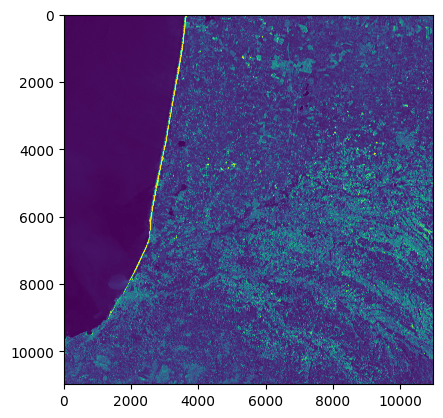

<Axes: >

In [12]:
show(raster_img)

In [13]:
# load covered zone of region
contour_path = os.path.join(DATA_PATH, "contour_zone.geojson")
zone_covered = gpd.read_file(contour_path).to_crs(LOCAL_CRS)
zone_covered

,geo_point_2d,gid,nom,depart,region,x_etiquet,y_etiquet,geometry
0,"{'lon': -1.19109737671, 'lat': 43.2580338058}",1,Frontière Pays Basque,PYRENEES-ATLANTIQUES,AQUITAINE,None,None,"MULTIPOLYGON (((626108.061 4791865.245, 626100..."


## Divide region into boxes

### Parameters

In [14]:
resolution = 10 # meters per pixel, used for raster dimension and satellite images
patch_dim = 255 # number of pixels

### Create a splitter to obtain a list of bboxes

In [15]:
splitter = UtmZoneSplitter(
    zone_covered.geometry.values,
    LOCAL_CRS,
    patch_dim * resolution)
bbox_list = np.array(splitter.get_bbox_list())
info_list = np.array(splitter.get_info_list())

### Prepare info of selected EOPatches

In [16]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]

idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({
    "index": idxs,
    "index_x": idxs_x,
    "index_y": idxs_y}, crs=LOCAL_CRS, geometry=geometry)

### Save to shapefile

In [17]:
shapefile_name = "grid_paysbasque_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

### Display boxes over covered region

<Axes: >

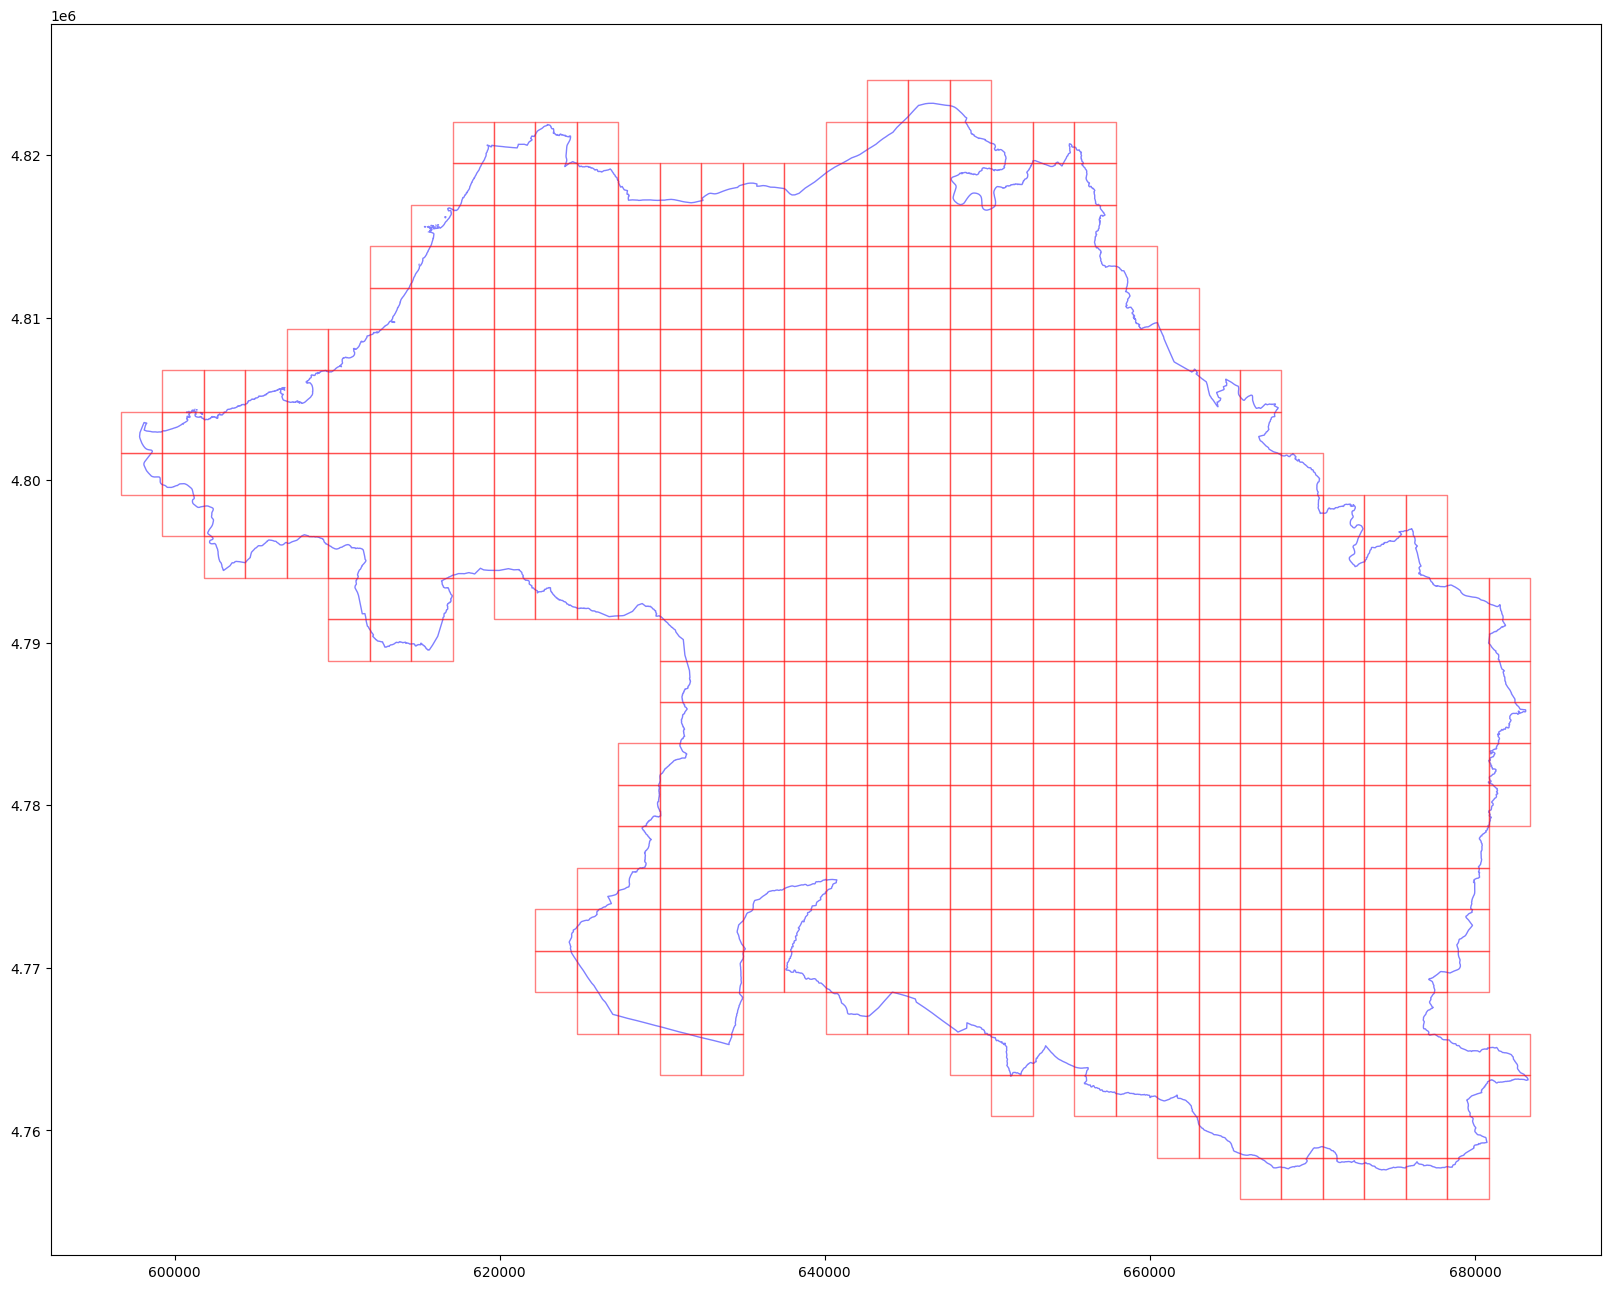

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
zone_covered.plot(ax=ax, facecolor="w", edgecolor="b")
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

## Create eopatches for covered region from sentinel image

In [19]:
sentinel_img_gpd = gpd.GeoDataFrame({
    "geometry": [Polygon([[lon, lat] for lat, lon in zone_coordinate])]
}, crs="EPSG:4326").to_crs(LOCAL_CRS)
sentinel_img_gpd

,geometry
0,"POLYGON ((600000.000 4900020.000, 709800.000 4..."


In [20]:
boundaries = sentinel_img_gpd.bounds.iloc[0].to_list()

In [21]:
eopatches = EOPatch(bbox=BBox(bbox=boundaries, crs=CRS('32630')))

if raster_img.ndim == 3:
    eopatches.data_timeless['BANDS'] = raster_img
else:
    eopatches.data_timeless['BANDS'] = raster_img[..., np.newaxis]

### Get parcelles_datas from DB or file if exists

In [22]:
parcelles_path = os.path.join(DATA_PATH, f"{REGION}_parcelles.geojson")

if not os.path.isfile(parcelles_path):
    conn = SQLConnection()
    parcelles_df = conn.get_parcelles_in_bbox(zone_covered.geometry, 2154)
    parcelles_df.to_file(parcelles_df, driver="GeoJSON") # save data to file
else:
    print("loading cache")
    parcelles_df = gpd.read_file(parcelles_path)
parcelles_df

loading cache


,primaryindex,id_parcel,surf_parc,code_cultu,code_group,culture_d1,culture_d2,geometry
0,4882922,6963839,0.77,PPH,18,,,"POLYGON ((364061.646 6247420.299, 364056.232 6..."
1,4882923,13884142,0.48,PPH,18,,,"POLYGON ((363913.467 6247352.908, 363938.717 6..."
2,4882924,6963770,0.48,PPH,18,,,"POLYGON ((363961.919 6247441.124, 363984.794 6..."
3,4882925,6963840,0.36,PPH,18,,,"POLYGON ((363915.899 6247347.118, 363954.146 6..."
4,4882926,6963762,1.18,PPH,18,,,"POLYGON ((363692.700 6246917.847, 363690.873 6..."
...,...,...,...,...,...,...,...,...
93214,6093220,18265244,2.18,PRL,18,,,"POLYGON ((356461.760 6253283.902, 356460.871 6..."
93215,6090969,18242516,0.29,SNE,28,,,"POLYGON ((357795.321 6258915.389, 357754.469 6..."
93216,6090972,18242520,0.96,BTA,28,,,"POLYGON ((395456.671 6265114.587, 395428.463 6..."
93217,6090973,18242521,0.03,BTA,28,,,"POLYGON ((367555.847 6263209.075, 367549.477 6..."


### EO-Learn workflow

In [58]:
vector_feature = FeatureType.VECTOR_TIMELESS, "RPG_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, parcelles_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "MASK"),
    values_column="code_group",
    raster_resolution=resolution,
    raster_dtype=np.uint8
)

save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

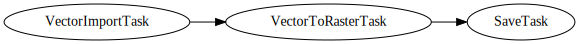

In [59]:
workflow_nodes = linearly_connect_tasks(
    vector_import_task, rasterization_task, save
)

workflow = EOWorkflow(workflow_nodes)

workflow.dependency_graph()

In [62]:
parcelles_df["code_group"] = parcelles_df.code_group.astype("int64")
parcelles_df.to_file(parcelles_path)
parcelles_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 93219 entries, 0 to 93218
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   primaryindex  93219 non-null  int64   
 1   id_parcel     93219 non-null  object  
 2   surf_parc     93219 non-null  float64 
 3   code_cultu    93219 non-null  object  
 4   code_group    93219 non-null  int64   
 5   culture_d1    93219 non-null  object  
 6   culture_d2    93219 non-null  object  
 7   geometry      93219 non-null  geometry
dtypes: float64(1), geometry(1), int64(2), object(4)
memory usage: 5.7+ MB


In [63]:
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
exec_args = []

for idx, bbox in enumerate(bbox_list[np.arange(0, 10, 1)]):
    exec_args.append(
        {
            input_node: {"bbox": bbox},
            save_node: {"eopatch_folder": f"eopatch_{idx}"}
        }
    )

executor = EOExecutor(workflow, exec_args, save_logs=True)
executor.run(workers=4)
executor.make_report()

100%|██████████| 10/10 [02:08<00:00, 12.86s/it]


In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(bbox_list[np.arange(0, 10, 1)]))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["RPG_colors_dict"].squeeze())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
# cb.set_ticks([entry.id for entry in LULC])
# cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();